# Introduction

In many simulations particles continuously enter the simulation domain while other particles leave the simulation domain. This example illustrates two key concepts in the coldatom library that can be used to deal with such situations: sources and sinks. We go over how to define a source and a sink and then we use these in conjunction with one another to simulate a collimated atomic beam generated by an oven.


# Sources

In the coldatom library, a source needs to have two essential capabilities. It needs to be able to tell us, how many particles it will generate the next time it is asked to produce particles. And then it needs to be able to generate the promised particles.

As an example, we consider a source that generates thermal atoms emitted from a circular aperture. First we include a few libraries:

In [1]:
import coldatoms
import numpy as np
%matplotlib ipympl
import matplotlib.pyplot as plt

Next we define our source:

In [2]:
class OvenSource(coldatoms.Source):
    
    def __init__(self, R, divergence, n_dot, v_bar, delta_v):
        """Create an OvenSource.
        
        R -- Radius of circular aperture of oven.
        divergence -- Divergence angle of atoms emitted by the oven.
        n_dot -- Number of atoms emitted per second.
        v_bar -- Average velocity of the emitted atoms.
        delta_v -- Standard deviation of velocities."""
        
        self.R = R
        self.divergence = divergence
        self.n_dot = n_dot
        self.v_bar = v_bar
        self.delta_v = delta_v
    
    def num_ptcls_produced(self, dt):
        n_bar = dt * self.n_dot
        return np.random.poisson(n_bar)

    def produce_ptcls(self, dt, start, end, ensemble):
        
        for i in range(start, end):
            # First we generate the positions
            while True:
                x = np.random.uniform(-1, 1)
                y = np.random.uniform(-1, 1)
                if (x*x + y*y) < 1:
                    break
            x *= self.R
            y *= self.R
        
            z = np.random.uniform(-self.v_bar * dt, 0)

            # Now generate the velocities
            vz = np.random.normal(self.v_bar, self.delta_v)
            vx = vz * np.random.normal(0, self.divergence)
            vy = vz * np.random.normal(0, self.divergence)

            ensemble.x[i, 0] = x
            ensemble.x[i, 1] = y
            ensemble.x[i, 2] = z
            ensemble.v[i, 0] = vx
            ensemble.v[i, 1] = vy
            ensemble.v[i, 2] = vz

Sources should derive from coldatoms.Source. In a time step of duration $dt$ we produce on average $dt \dot{n}$ particles. The actual number of particles produced changes each time we generate particles. The distribution of particles is a Poissonian with mean $dt \dot{n}$.

When we are then asked to actually generate the particles and insert them into the ensemble we uniformly distribute them over a circular disk of radius $R$ in the $x--y$ plane. The particles are moving in the positive $z$ direction. The starting position is uniformly distributed along $z$ such that there are no gaps and bunches of the particles. They should emerge from the oven as a uniform stream.

Then we produce the velocity distribution. In OvenSource we specify the velocity distribution kinematically, i.e. we describe the velocity distribution directly. This is because a more physical distribution (e.g in terms of temperature) requires more parameters (e.g. particle mass and Boltzmann constant). It is easy for the calling code to determine 
$\bar{v}$ and $\Delta v$ from a physical model.

Note that due to the beam's divergence the diameter of the disk from which particles are emitted is slightly larger than $R$. This is an artifact our simplistic treatment of the initial positions of the particle. Some particles start a distance before the aperture and in general they have a non-zero transverse velocity. A particle starting out very close to the edge of the aperture but with an outward transverse velocity component will pass through the $z=0$ plane outside of the disk with radius $R$.

So now lets create one of these sources:

In [3]:
src = OvenSource(R=1.0e-3, divergence=1.0e-2, n_dot=1.0e9, v_bar=100.0, delta_v=10.0)

In $1 \mu \rm{s}$ the source emits on average 1000 particles:

In [4]:
src.num_ptcls_produced(1.0e-6)

948

To actually generate particles we first need an ensemble into which the particles are to be inserted.

In [5]:
ensemble = coldatoms.Ensemble(num_ptcls=0)

In [6]:
coldatoms.produce_ptcls(1.0e-6, ensemble, sources=[src])

Now our ensemble contains particles:

In [7]:
ensemble.num_ptcls

1020

Here is a snapshot of the positions of the particles we just created, looking into the beam:

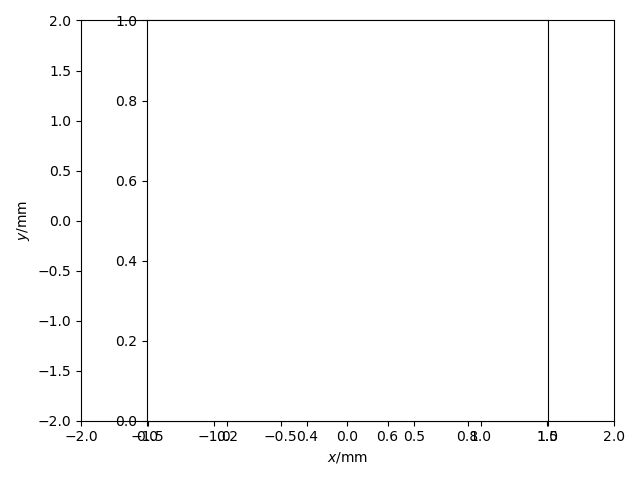

In [8]:
fig = plt.figure()
plt.plot(1.0e3*ensemble.x[:,0], 1.0e3*ensemble.x[:, 1], '.', markersize=3)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel(r'$x/\rm{mm}$')
plt.ylabel(r'$y/\rm{mm}$')
plt.axes().set_aspect(1)
fig.tight_layout()

And here is a view from the side:

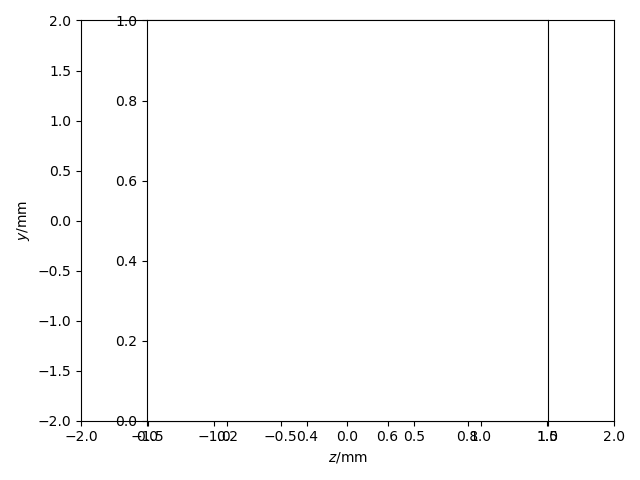

In [9]:
fig = plt.figure()
plt.plot(1.0e3*ensemble.x[:,2], 1.0e3*ensemble.x[:, 1], '.', markersize=3)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel(r'$z/\rm{mm}$')
plt.ylabel(r'$y/\rm{mm}$')
plt.axes().set_aspect(1)
fig.tight_layout()

The atomic density distribution has this thin pancake shape because at a velocity of 100m/s they only travel 0.1mm in $dt$.

The density distribution of the particles is Gaussian in the transverse direction (with mean $0$) and in the direction along the beam (with mean $\mathbf{v}=(0,0,100\rm{m/s})^T$:

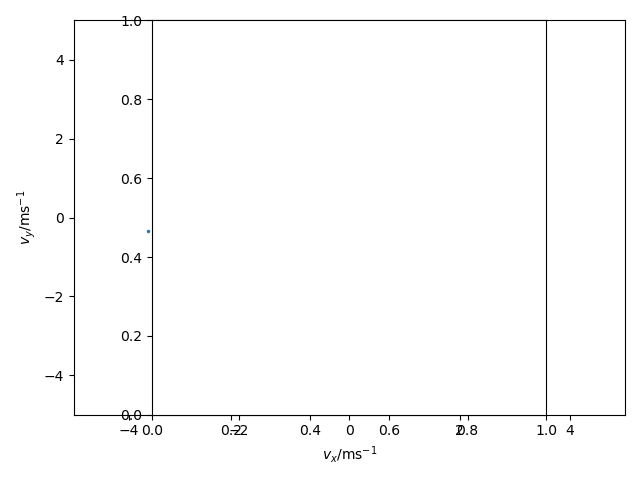

In [15]:
fig = plt.figure()
plt.plot(ensemble.v[:,0], ensemble.v[:, 1], '.', markersize=3)
vmax = 5
plt.xlim([-vmax, vmax])
plt.ylim([-vmax, vmax])
plt.xlabel(r'$v_x/\rm{ms^{-1}}$')
plt.ylabel(r'$v_y/\rm{ms^{-1}}$')
plt.axes().set_aspect(1)
fig.tight_layout()

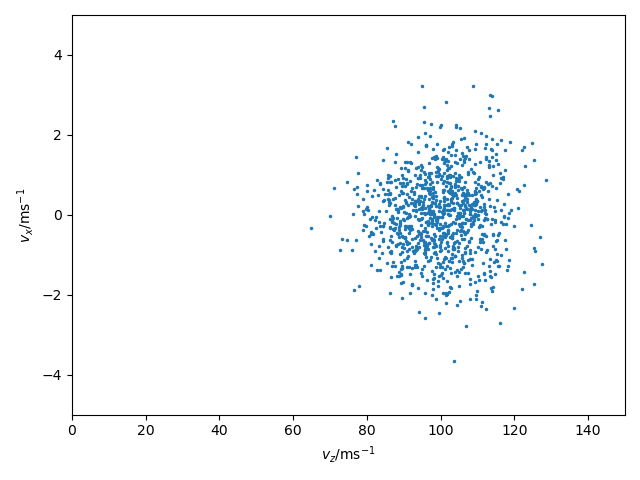

In [11]:
fig = plt.figure()
plt.plot(ensemble.v[:,2], ensemble.v[:, 0], '.', markersize=3)
vmax = 5
plt.xlim([-0, 30*vmax])
plt.ylim([-vmax, vmax])
plt.xlabel(r'$v_z/\rm{ms^{-1}}$')
plt.ylabel(r'$v_x/\rm{ms^{-1}}$')
fig.tight_layout()

Now, if we want to generate a particle beam we cannot simply keep generating particles. The particles would simply be generated on top of one another. Their density would keep increasing but they wouldn't form a beam.

To produce a beam we have to let the particles move. For that purpose we can use the drift-kick particle push and simply interleave it with the production of particles. Here is the resulting evolution of the particle beam during the first $20 \mu\rm{s}$.

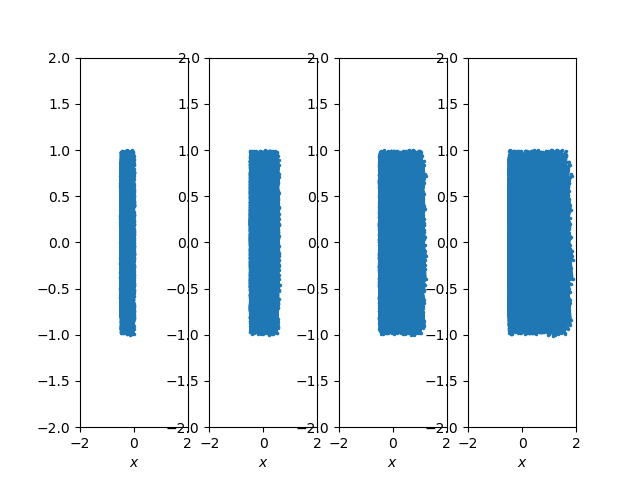

In [16]:
fig = plt.figure()
subplots = [plt.subplot(141), plt.subplot(142), plt.subplot(143), plt.subplot(144)]

dt = 5.0e-6
ensemble = coldatoms.Ensemble(num_ptcls=0)
for ax in subplots:
    coldatoms.produce_ptcls(dt, ensemble, sources=[src])
    ax.plot(1.0e3*ensemble.x[:,2], 1.0e3*ensemble.x[:, 1], marker='.', markersize=3)
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    coldatoms.drift_kick(dt, ensemble)
    ax.set_xlabel(r'$x$')

# Sinks

Besides particle sources we also need a mechanism to remove particles from the simulation. Sometimes this is just a practical matter: Some particles may have escaped a trapping potential and moved to a location where they do not participate in the dynamics of the ensemble in an interesting way. We will then want to remove them from the ensemble so that they don't slow down the simulation unnecessarily. We could imagine surrouding the simulation domain by a box that absorbs any particles hitting its boundary. This is particularly important if we have a source that continuously emits particles into the simulation. Without sinks it would be impossible to reach steady state.

In other cases the absorption is a more physically real process. For example, the atoms in an atom beam may hit an aperture that is used to collimate the beam.

Conceptually, sinks are represented by surfaces in the coldatoms library. When a particle crosses the surface, it will be removed from the simulations. To implement a sink, we derive from the Sink class. We need to implement two essential methods. find\_absorption\_time computes the time at which a particle starting at position $x$ and moving along a straight line with velocity $v$ for a time $dt$ will hit the absorbing surface. If the particle will not cross the surface (or if the sink will not absorb the particle for a different reason) the sink should return an absorption time outside the interval $[0, dt]$.

After the absorption time has been computed, coldatoms calls the sink's record\_absorption method. This method call gives the sink a chance to process the absorption of a particle. For example, the sink may log the absorption to a file or add the absorption position to an array of absorption events for visualization.

To illustrate the process we consider a circular aperture. We model the aperture as a circular hole drilled into a plane.

In [17]:
class SinkCircularAperture(coldatoms.Sink):
    """A sink representing a circular aperture.
    
    The aperture is defined by the center of the aperture, the aperture's radius,
    and the normal of the plane in which the aperture is situated.
    """
    
    def __init__(self, center, radius, normal):
        """Create a circular aperture sink.
        
        center -- The center of the circular apertur.
        radius -- Radius of the aperture.
        normal -- Normal of the plane in which the aperture is cut.
        """
        self.center = np.copy(center)
        self.radius = radius
        self.normal = np.copy(normal)
        
    def find_absorption_time(self, x, v, dt):
        num_ptcls = x.shape[0]
        taus = np.empty(num_ptcls)

        for i in range(num_ptcls):
            normal_velocity = self.normal.dot(v[i])
            # Deal with particles that travel parallel to the plane in which
            # the aperture lies.
            if (normal_velocity == 0.0):
                taus[i] = 2.0 * dt
            else:
                # First we compute the time at which the particle intersects
                # the plane in which the aperture lies.
                taus[i] = self.normal.dot(self.center - x[i]) / normal_velocity
                intersection = x[i] + taus[i] * v[i]
                distance_from_center = np.linalg.norm(intersection - self.center)
                if distance_from_center < self.radius:
                    # Intersects within the aperture, so don't absorb.
                    taus[i] = 2.0 * dt

        return taus
    
    def absorb_particles(self, ensemble, dt, absorption_times, absorption_indices):
        print("The following particles will be absorbed:")
        print(absorption_indices)

To see how this works we'll consider a specific example. A circular aperture in the $y-z$ plane with radius 1. We'll have a look at the fate of three particles: The first is traveling away from the aperature, the second hits the aperture, and the third one hits the plane outside of the aperture. As expected, only the third particle gets absorbed (its index is 2 because numpy and python indexing is zero based):

In [18]:
aperture = SinkCircularAperture(
    center=np.array([0.0, 0.0, 0.0]), radius=1.0, normal=np.array([1.0, 0.0, 0.0]))
ensemble = coldatoms.Ensemble(num_ptcls=3)
ensemble.x = np.array([[-1.0, 0.0, 0.0], [-1.0, 0.0, 0.0], [-1.0, 0.0, 0.0]])
ensemble.v = np.array([[-1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 4.0, 0.0]])
coldatoms.process_sink(10.0, ensemble, aperture)

And after the sink has been processed, the ensemble contains only two particles:

In [19]:
print(ensemble.num_ptcls)
print(ensemble.v)

2
[[-1.  0.  0.]
 [ 1.  0.  0.]]


# A collimated atom beam

With our oven source and circular aperture we have the building blocks of a collimated beam experiment. All we need to do is combine source, sink, and particle push algorithm. We have already seen above that sources and particle push can be combined rather easily. We simply need to generate particles at each time step and then update the particle positions with the particle push.

Unfortunately, combining sinks with the particle push is not quite as straightforward in general. The fundamental reason for this is that sinks demand that particle motion be along a straight line. The velocity must not change during the time step. Granted, in our case this is what happens because we are neglecting all forces acting on the particles and they therefore move along straight lines. However, in general this is not the case. When there are forces acting on the particles our drift-kick integrator produces trajectories with a kink.

This means that the particle push itself has to be informed about the sinks. It can then process the sinks for each of the straight line segment making up the particle trajectory.

First we define the atom source representing the oven:

In [20]:
beam_source = OvenSource(R=1.0e-3, divergence=1.0e-2, n_dot=1.0e7, v_bar=300.0, delta_v=10.0)

Remember that our oven source is located at the origin, emitting particles from a circular disk in the $x-y$ plane moving in the positive $z$ direction. We place an aperture of diameter $1{\rm mm}$ at a distance of $0.5m$ downstream from the source. At this location the beam expands to about $17{\rm mm}$, so a significant fraction of the atoms get absorbed by the aperture.

In [21]:
beam_aperture = SinkCircularAperture(
    center=np.array([0.0, 0.0, 0.5]), radius=1.0e-3, normal=np.array([0.0, 0.0, 1.0]))

We integrate the particle motion with a time step size of $dt=1.0 \times 10^{-4}{\rm s}$. During that time the particles travel $3{\rm cm}$ on average. 

In [22]:
%%capture
beam_ensemble = coldatoms.Ensemble(num_ptcls=0)
dt = 1.0e-4
for i in range(30):
    coldatoms.produce_ptcls(dt, beam_ensemble, sources=[beam_source])
    coldatoms.drift_kick(dt, beam_ensemble, forces=[], sink=beam_aperture)

The following picture shows a side view of the beam:

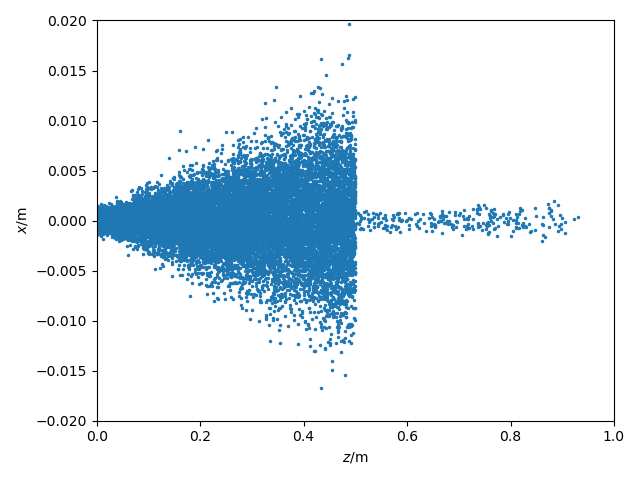

In [23]:
fig = plt.figure()
plt.plot(beam_ensemble.x[:,2], beam_ensemble.x[:, 0], '.', markersize=3)
plt.xlim([-0, 1.0])
plt.ylim([-20.0e-3, 20.0e-3])
plt.xlabel(r'$z/\rm{m}$')
plt.ylabel(r'$x/\rm{m}$')
fig.tight_layout()